In [1]:
import numpy as np
import os
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from target import Target
from retrieval import Retrieval
from parameters import Parameters

brown_dwarf = '2M0355' # options: 2M0355 or 2M1425
chem = 'freechem' # options: freechem or equchem
PT_type = 'PTgrad' # options: PTknot or PTgrad
Nlive=400 # number of live points
tol=0.4 # evidence tolerance
output=f'{chem}_{PT_type}_N{Nlive}_ev{tol}' # output folder name

brown_dwarf = Target(brown_dwarf)

cloud_mode='gray' # options: None, gray, or MgSiO3
GP=True # options: True/False

constant_params={} # add if needed
free_params = {'rv': ([2,20],r'$v_{\rm rad}$'),
               'vsini': ([0,40],r'$v$ sin$i$'),
               'log_g':([3,5],r'log $g$'),
               'epsilon_limb': [(0.2,1), r'$\epsilon_\mathrm{limb}$']} # limb-darkening coefficient (0-1)

if PT_type=='PTknot':
    pt_params={'T0' : ([1000,4000], r'$T_0$'), # bottom of the atmosphere (hotter)
            'T1' : ([0,4000], r'$T_1$'),
            'T2' : ([0,4000], r'$T_2$'),
            'T3' : ([0,4000], r'$T_3$'),
            'T4' : ([0,4000], r'$T_4$'),} # top of atmosphere (cooler)
    free_params.update(pt_params)

if PT_type=='PTgrad':
    pt_params={'dlnT_dlnP_0': ([0.,0.4], r'$\nabla_{T,0}$'), # gradient at T0 
            'dlnT_dlnP_1': ([0.,0.4], r'$\nabla_{T,1}$'), 
            'dlnT_dlnP_2': ([0.,0.4], r'$\nabla_{T,2}$'), 
            'dlnT_dlnP_3': ([0.,0.4], r'$\nabla_{T,3}$'), 
            'dlnT_dlnP_4': ([0.,0.4], r'$\nabla_{T,4}$'), 
            'T0': ([1000,4000], r'$T_0$')} # at bottom of atmosphere
    free_params.update(pt_params)

# if equilibrium chemistry, define [Fe/H], C/O, and isotopologue ratios
if chem=='equchem':
    chemistry={'C/O':([0,1], r'C/O'), 
            'Fe/H': ([-1.5,1.5], r'[Fe/H]'), 
            'C13_12_ratio': ([1e-10,1e-1], r'$\mathrm{^{13}C/^{12}C}$'), 
            'O18_16_ratio': ([1e-10,1e-1], r'$\mathrm{^{18}O/^{16}O}$'), 
            'O17_16_ratio': ([1e-10,1e-1], r'$\mathrm{^{17}O/^{12}O}$')}
    
# if free chemistry, define VMRs
if chem=='freechem': 
    chemistry={'log_H2O':([-12,-1],r'log H$_2$O'),
            'log_12CO':([-12,-1],r'log $^{12}$CO'),
            'log_13CO':([-12,-1],r'log $^{13}$CO'),
            'log_C18O':([-12,-1],r'log C$^{18}$O'),
            'log_C17O':([-12,-1],r'log C$^{17}$O'),
            'log_CH4':([-12,-1],r'log CH$_4$'),
            'log_NH3':([-12,-1],r'log NH$_3$'),
            'log_HCN':([-12,-1],r'log HCN'),
            'log_HF':([-12,-1],r'log HF'),
            'log_H2(18)O':([-12,-1],r'log H$_2^{18}$O'),
            'log_H2S':([-12,-1],r'log H$_2$S'),
            'log_OH':([-12,-1],r'log OH'),
            'log_CO2':([-12,-1],r'log CO$_2$')}
    
if cloud_mode=='gray':
    cloud_props={'log_opa_base_gray': ([-10,3], r'log $\kappa_{\mathrm{cl},0}$'),  
                'log_P_base_gray': ([-6,3], r'log $P_{\mathrm{cl},0}$'), # pressure of gray cloud deck
                'fsed_gray': ([0,20], r'$f_\mathrm{sed}$')} # sedimentation parameter for particles
    free_params.update(cloud_props)

if cloud_mode=='MgSiO3':
    cloud_props={'fsed': ([0,20], r'$f_\mathrm{sed}$'), # sedimentation parameter for particles
                'sigma_lnorm': ([0.8,1.5], r'$\sigma_{l,norm}$'), # width of the log-normal particle distribution
                'log_Kzz':([5,15],r'log $K_{zz}$')} # eddy diffusion parameter (atmospheric mixing)
    free_params.update(cloud_props)
    
if GP==True: # add uncertainty scaling
    GP_params={'log_a': ([-1,1], r'$\log\ a$'), # one is enough, will be multipled with order/det error
               'log_l': ([-3,0], r'$\log\ l$')}
    free_params.update(GP_params)

free_params.update(chemistry)
parameters = Parameters(free_params, constant_params)
cube = np.random.rand(parameters.n_params)
parameters(cube)
params=parameters.params

retrieval=Retrieval(target=brown_dwarf,parameters=parameters,
                    output_name=output,chemistry=chem,
                    cloud_mode=cloud_mode,GP=GP,PT_type=PT_type)
#retrieval.PMN_run(N_live_points=50,evidence_tolerance=50)
#retrieval.evaluate()

In [3]:
molecules=['H2O','HF','13CO','12CO','C17O','C18O','H2(18)O','CH4','NH3','H2S','HCN','OH','CO2']
retrieval.cross_correlation(molecules)

/home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/pRT_model.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spectrum_orders/=np.nanmedian(get_median) # orders not same size, np.median didn't work otherwise
/home/natalie/Desktop/files/uni/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/pRT_model.py:318: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spectrum_orders/=np.nanmedian(get_median) # orders not same size, np.median didn't work otherwise
/home/natalie/Desktop/files/uni/PhD/SupJup/codes

In [ ]:
retrieval.cross_correlation('H2O')

In [31]:
import pickle
import pathlib
path=pathlib.Path('/home/natalie/Desktop/atm_retrieval/2M0355/2M0355_freechem_PTgrad/final_params_dict.pickle')
with open(path,'rb') as file:
    final_params=pickle.load(file)
molecule='13CO'
final_params[f'log_{molecule}']=-12
final_params

{'rv': 13.239141683265826,
 'rv_err': (-0.010459223148483687, 0.011138159615386556),
 'rv_bf': 13.250375504449462,
 'vsini': 3.1521212244427215,
 'vsini_err': (-0.11217596076235248, 0.10137427620419981),
 'vsini_bf': 3.2687465998293694,
 'log_g': 4.849039310151273,
 'log_g_err': (-0.05067910765419281, 0.04691240284116738),
 'log_g_bf': 4.839614328362659,
 'epsilon_limb': 0.7080679133644965,
 'epsilon_limb_err': (-0.2067613514873261, 0.166715415957431),
 'epsilon_limb_bf': 0.9151599927064991,
 'dlnT_dlnP_0': 0.17843266584089304,
 'dlnT_dlnP_0_err': (-0.08338800184330118, 0.08880463430896515),
 'dlnT_dlnP_0_bf': 0.12589478811454247,
 'dlnT_dlnP_1': 0.25421523558463033,
 'dlnT_dlnP_1_err': (-0.020260324267192986, 0.023920759751901277),
 'dlnT_dlnP_1_bf': 0.25334854381778377,
 'dlnT_dlnP_2': 0.03988012478702552,
 'dlnT_dlnP_2_err': (-0.0019037803897285974, 0.0019396779685628071),
 'dlnT_dlnP_2_bf': 0.03896971121732107,
 'dlnT_dlnP_3': 0.044737540100713624,
 'dlnT_dlnP_3_err': (-0.001092735

# Fix plots

/home/natalie/.local/lib/python3.8/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(


NameError: name 'output_dir' is not defined

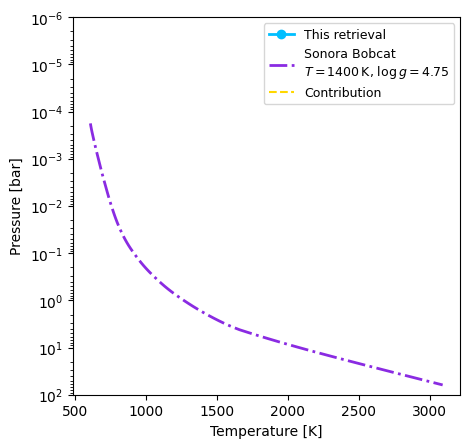

In [32]:
import matplotlib.pyplot as plt
import cloud_cond as cloud_cond
import numpy as np
from labellines import labelLine, labelLines
from matplotlib.lines import Line2D

fig,ax=plt.subplots(1,1,figsize=(5,5),dpi=100)

pressure = np.logspace(-6,2,50)


#ax.plot(temperature,pressure,color='deepskyblue',lw=2)
#ax.scatter(retrieval.final_object.t_samp,10**retrieval.final_object.p_samp,color='deepskyblue')
#xmin=np.min(retrieval.final_object.t_samp)-100
#xmax=np.max(retrieval.final_object.t_samp)+100

ax.set(xlabel='Temperature [K]', ylabel='Pressure [bar]', yscale='log', 
    ylim=(np.nanmax(pressure),np.nanmin(pressure)))
    #xlim=(xmin,xmax))

# T=1400K, logg=4.65 -> 10**(4.65)/100 =  446 m/s²
file=np.loadtxt('t1400g562nc_m0.0.dat')
pres=file[:,1] # bar
temp=file[:,2] # K
ax.plot(temp,pres,linestyle='dashdot',c='blueviolet',linewidth=2)

# https://github.com/cphyc/matplotlib-label-lines
labelLines(ax.get_lines(),align=False,fontsize=9,drop_label=True)
lines = [Line2D([0], [0], marker='o', color='deepskyblue', markerfacecolor='deepskyblue' ,linewidth=2, linestyle='-'),
        Line2D([0], [0], color='blueviolet', linewidth=2, linestyle='dashdot'),
        Line2D([0], [0], color='gold', linewidth=1.5, linestyle='--')]
labels = ['This retrieval', 'Sonora Bobcat \n$T=1400\,$K, log$\,g=4.75$','Contribution']
ax.legend(lines,labels,fontsize=9)

callback_label='live_'
params_pm=np.load(f'{output_dir}/{callback_label}params_pm.npy')
indices=[]
for key in ['T1','T2','T3','T4']:
    idx=list(params).index(key)
    indices.append(idx)
T_pm=np.array([params_pm[:,i] for i in indices]).T # mean, lower, upper
lowers=T_pm[1][::-1] # reverse order so that T4,T3,T2,T1
uppers=T_pm[2][::-1]
from scipy.interpolate import CubicSpline
p_samp= np.linspace(np.log10(np.nanmin(pressure)),np.log10(np.nanmax(pressure)),len(uppers))
#sort = np.argsort(p_samp)
lower = CubicSpline(p_samp,lowers)(np.log10(pressure))
upper = CubicSpline(p_samp,uppers)(np.log10(pressure))
#ax.plot(self.final_object.temperature, self.final_object.pressure,color='deepskyblue',lw=2
ax.scatter(lowers,10**p_samp)
ax.scatter(uppers,10**p_samp)
ax.fill_betweenx(pressure,lower,upper,color='deepskyblue',alpha=0.2)
#ax.plot(T_pm[0],p_samp,color='deepskyblue',lw=2)

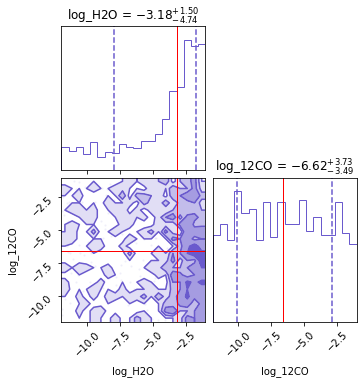

In [ ]:
import corner

output_dir='/home/natalie/Desktop/PhD/SupJup/codes/retrieval_base/atm_retrieval/atm_retrieval/2M0355_test7'
posterior=np.load(f'{output_dir}/live_posterior.npy')
abunds=['log_H2O','log_12CO']
indices=[]
for key in abunds:
    idx=list(params).index(key)
    indices.append(idx)
new_posterior=np.array([posterior[:,i] for i in indices]).T

fig = corner.corner(new_posterior, 
                    labels=abunds, 
                    title_kwargs={'fontsize': 12},
                    color='slateblue',
                    linewidths=0.5,
                    fill_contours=True,
                    quantiles=[0.16,0.84],
                    show_titles=True
                    )

quantiles = np.array([np.percentile(new_posterior[:,i], [16.0,50.0,84.0], axis=-1) for i in range(new_posterior.shape[1])])
means=quantiles[:,1] # mean of all params
uppers=quantiles[:,2]-means # +error
lowers=quantiles[:,0]-means # -error
corner.overplot_lines(fig, means,color='r',lw=1,linestyle='solid') # plot mean, second column
#corner.overplot_lines(fig, means+uppers,color='c',lw=1,linestyle='solid')
#corner.overplot_lines(fig, means+lowers,color='m',lw=1,linestyle='solid')


# Check species missing in fit, lines not included in model

# Make plots for presentation

In [ ]:
import getpass
import os
import numpy as np
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1' # to avoid using too many CPUs

if getpass.getuser() == "grasser": # when runnig from LEM
    os.environ['pRT_input_data_path'] ="/net/lem/data2/pRT_input_data"
    os.environ['OMP_NUM_THREADS'] = '1' # important for MPI
    from mpi4py import MPI 
    comm = MPI.COMM_WORLD # important for MPI
    rank = comm.Get_rank() # important for MPI
    from atm_retrieval.target import Target
    from atm_retrieval.likelihood import Retrieval
    from atm_retrieval.parameters import Parameters
    import matplotlib
    matplotlib.use('Agg') # disable interactive plotting
elif getpass.getuser() == "natalie": # when testing from my laptop
    os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
    from target import Target
    from likelihood import Retrieval
    from parameters import Parameters
    from pRT_model import pRT_spectrum


M0355 = Target('2M0355')
data_wave,data_flux,data_err=M0355.load_spectrum()

constant_params = {'vsini': 2, # rotational velocity
                'rv': 11.92,
                'log_Kzz': 7.5, # eddy diffusion parameter (atmospheric mixing)
                'fsed': 2, # sedimentation parameter for particles
                'P_base_gray': 1, # pressure of gray cloud deck
                'fsed_gray': 2,
                'opa_base_gray': 0.8, # opacity of gray cloud deck
                'sigma_lnorm': 1.05, # width of the log-normal particle distribution of MgSiO3
                'log_MgSiO3' : 0, # scaling wrt chem equilibrium, 0 = equilibrium abundance 
                'log_H2O': -2.9,#-2.9,
                'log_12CO': -2.67,#-2.66,
                'log_13CO':-4.9,
                'log_C18O':-12, #-8.3,
                'log_C17O':-12,  #-8.7,
                'log_CH4':-12, #-8.6,
                'log_NH3':-12, #-8.9,
                'log_HCN':-12, #-8,
                'T1' : 2500, # bottom of the atmosphere (hotter)
                'T2' : 1500,
                'T3' : 1270,
                'T4' : 313, # top of atmosphere (cooler)
                'log_g':4.95,
                } 

free_params = {}
parameters = Parameters(free_params,constant_params)
params=parameters.params


output='2M0355_test4'
retrieval=Retrieval(target=M0355,parameters=parameters,output_name=output)
atmosphere_objects=retrieval.atmosphere_objects

species=retrieval.get_species(param_dict=parameters.params)
model_flux=pRT_spectrum(parameters=params,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()


In [ ]:
params_H2O=params.copy()
params_H2O['log_12CO']=-12
params_H2O['log_13CO']=-12
H2O_flux=pRT_spectrum(parameters=params_H2O,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

params_CO=params.copy()
params_CO['log_H2O']=-12
params_CO['log_13CO']=-12
CO_flux=pRT_spectrum(parameters=params_CO,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()

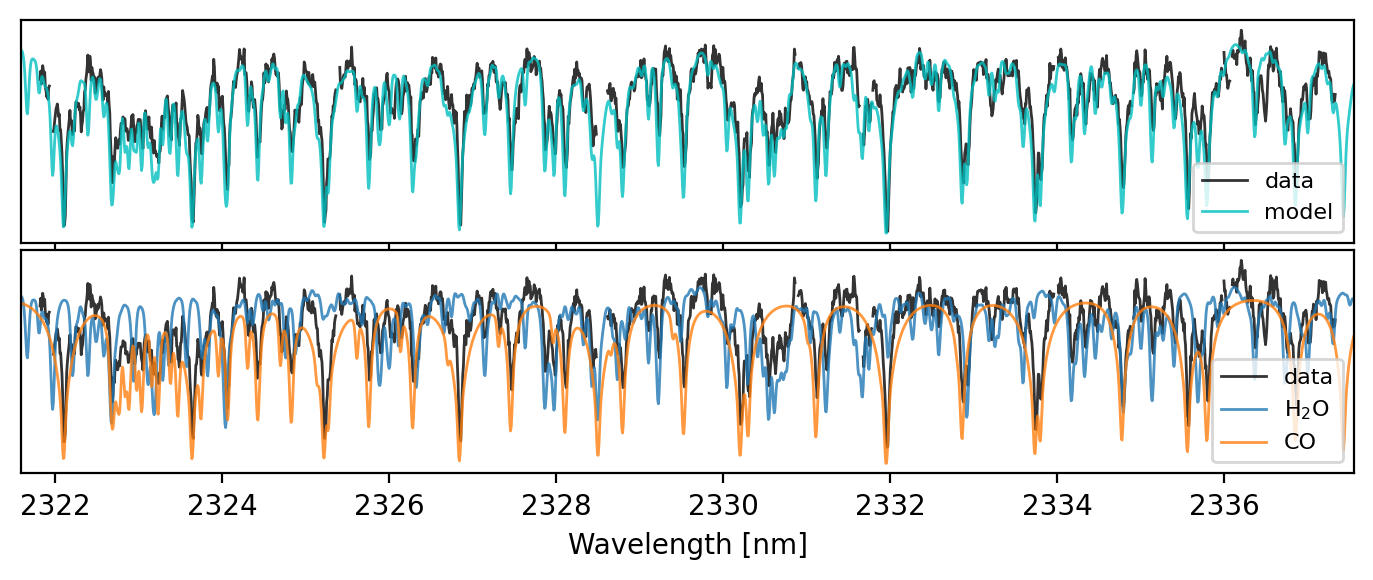

: 

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(7,3),dpi=200,sharex=True)
order=5
det=0
for i in range(2):
    ax[i].plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
    ax[i].set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
    ax[i].yaxis.set_visible(False) # remove ylabels because anyway unitless

ax[0].plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
ax[1].plot(data_wave[order,det],H2O_flux[order,det],lw=1,alpha=0.8,c='tab:blue',label='H$_2$O')
ax[1].plot(data_wave[order,det],CO_flux[order,det],lw=1,alpha=0.8,c='tab:orange',label='CO')

ax[0].legend(fontsize=8)
ax[1].legend(fontsize=8)
ax[1].set_xlabel('Wavelength [nm]')
fig.tight_layout(h_pad=-0.1)
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/spectrum.jpg')

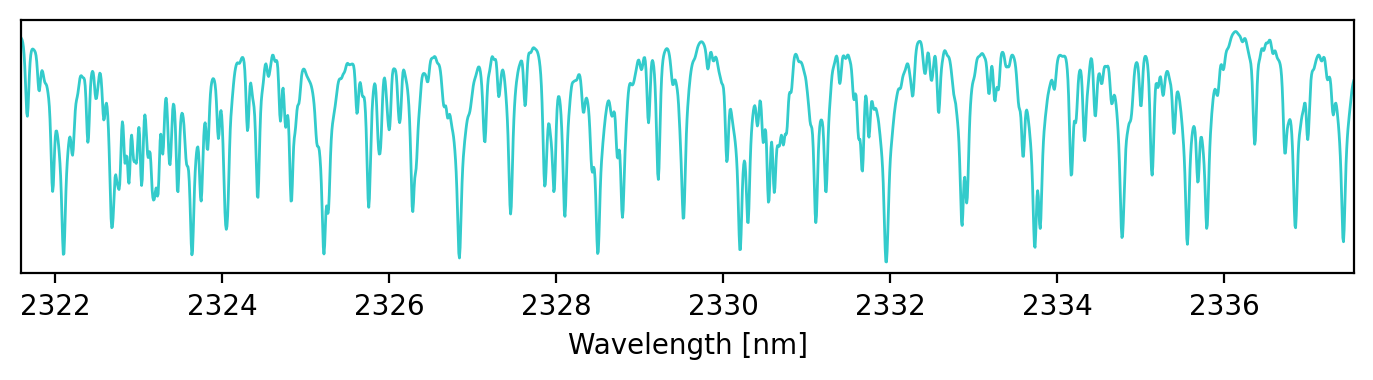

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],model_flux[order,det],lw=1,alpha=0.8,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/model.jpg')

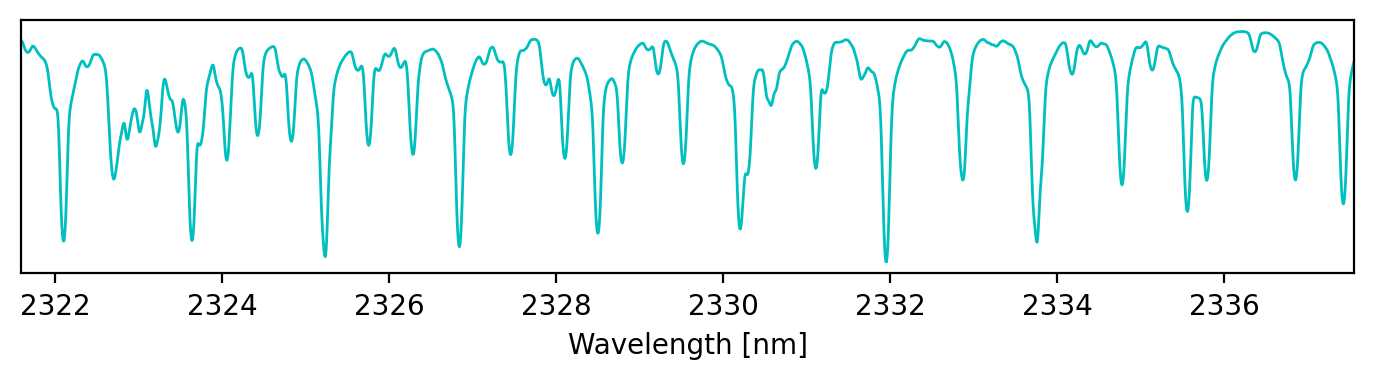

In [ ]:
params_bad=params.copy()
params_bad['log_H2O']=-3.5
params_bad['log_CO']=-2
params_bad['vsini']=7
params_bad['T1']=1700
bad_flux=pRT_spectrum(parameters=params_bad,data_wave=data_wave,target=M0355,
                        atmosphere_objects=atmosphere_objects,species=species,
                        free_chem=True).make_spectrum()
fig,ax=plt.subplots(1,1,figsize=(7,2),dpi=200,sharex=True)
order=5
det=0
#ax.plot(data_wave[order,det],data_flux[order,det],lw=1,alpha=0.8,c='k',label='data')
ax.set_xlim(np.nanmin(data_wave[order,det]),np.nanmax(data_wave[order,det]))
ax.plot(data_wave[order,det],bad_flux[order,det],lw=1,alpha=1,c='c',label='model')
#ax.legend(fontsize=8)
ax.yaxis.set_visible(False) # remove ylabels because anyway unitless
ax.set_xlabel('Wavelength [nm]')
fig.tight_layout()
fig.savefig('/home/natalie/Desktop/PhD/SupJup/plots/bad_model1.jpg')